In [1]:
import os
import cv2
import random
import warnings
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import os
from sklearn.model_selection import train_test_split
import shutil


dataset_path = '/kaggle/input/garbage-classification/garbage_classification'


classes = os.listdir(dataset_path)
print(classes)

['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']


In [3]:
base_dir = '/kaggle/working/garbage-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for category in classes:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)


In [4]:
for category in classes:
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)
    
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)
    
    for image in train_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category, image))
        
    for image in val_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(val_dir, category, image))
        
    for image in test_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category, image))


In [5]:
def count_files(directory):
    count = 0
    for category in classes:
        count += len(os.listdir(os.path.join(directory, category)))
    return count

print(f"Train set: {count_files(train_dir)} images")
print(f"Validation set: {count_files(val_dir)} images")
print(f"Test set: {count_files(test_dir)} images")


Train set: 10854 images
Validation set: 2328 images
Test set: 2333 images


In [6]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))
num_of_classes(train_dir, 'train')
num_of_classes(val_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 12
number of classes in validation folder : 12
number of classes in test folder : 12


In [7]:
def create_df(folder_path) :
    all_images = []    
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [8]:
train_df = create_df(train_dir)
validation_df = create_df(val_dir)
test_df = create_df(test_dir)

In [9]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 10854
Number of samples in validation : 2328
Number of samples test : 2333


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=12,                  
    shuffle=True,
    seed=42,
    
)

Found 10854 validated image filenames belonging to 12 classes.


In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=12,
    seed=42,
    shuffle=False
)

Found 2328 validated image filenames belonging to 12 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=12,
    seed=42,
    shuffle=False
)

Found 2333 validated image filenames belonging to 12 classes.


In [14]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=None, 
    pooling='avg'
)


pre_trained_model.load_weights('/kaggle/input/mobile/keras/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top (1).h5')

In [15]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)

input_layer_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

In [16]:
pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [19]:

model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))

In [20]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

In [21]:
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True) 

earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [23]:
x_val, y_val = next(validation_generator)
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")


x_val shape: (12, 224, 224, 3)
y_val shape: (12, 12)


In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=1,  
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/100
905/905 ━━━━━━━━━━━━━━━━━━━━ 309s 340ms/step - accuracy: 0.8760 - loss: 0.4051 - val_accuracy: 0.6667 - val_loss: 2.1614 - learning_rate: 0.0010
Epoch 2/100
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5833 - val_loss: 2.2044 - learning_rate: 0.0010
Epoch 3/100
905/905 ━━━━━━━━━━━━━━━━━━━━ 328s 348ms/step - accuracy: 0.8951 - loss: 0.3414 - val_accuracy: 0.8333 - val_loss: 0.4886 - learning_rate: 0.0010
Epoch 4/100
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4167 - val_loss: 2.9434 - learning_rate: 0.0010
Epoch 5/100
905/905 ━━━━━━━━━━━━━━━━━━━━ 311s 342ms/step - accuracy: 0.9098 - loss: 0.2898 - val_accuracy: 0.8333 - val_loss: 0.8005 - learning_rate: 0.0010
Epoch 6/100
905/905 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0666 - learning_rate: 0.0010
Epoch 7/100
905/905 ━━━━━━━━━━━━━━━━━━━━

In [25]:
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
33,0.000000,0.000000,0.916667,0.167612,0.000008
34,0.986457,0.040776,0.916667,0.341923,0.000008
35,0.000000,0.000000,1.000000,0.020663,0.000008
36,0.987286,0.039572,0.916667,0.100046,0.000004
37,0.000000,0.000000,0.916667,0.240019,0.000004


In [26]:
best_model = models.load_model('MyModel.keras')

In [30]:
test_loss, test_acc = best_model.evaluate(test_generator)

print(f'Test Loss : {round(test_loss, 3)}')
print(f'Test Accuracy : {round(test_acc, 3)}')

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 52s 252ms/step - accuracy: 0.9419 - loss: 0.2889
Test Loss : 0.178
Test Accuracy : 0.962


In [31]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

194/194 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step
              precision    recall  f1-score   support

     battery       0.95      0.99      0.97       142
  biological       0.97      0.99      0.98       148
 brown-glass       0.97      0.95      0.96        91
   cardboard       0.98      0.90      0.94       134
     clothes       0.99      0.99      0.99       799
 green-glass       0.96      0.95      0.95        94
       metal       0.87      0.90      0.88       115
       paper       0.92      0.94      0.93       157
     plastic       0.87      0.89      0.88       130
       shoes       0.97      0.95      0.96       297
       trash       0.98      0.98      0.98       105
 white-glass       0.94      0.91      0.93       116

    accuracy                           0.96      2328
   macro avg       0.95      0.94      0.95      2328
weighted avg       0.96      0.96      0.96      2328





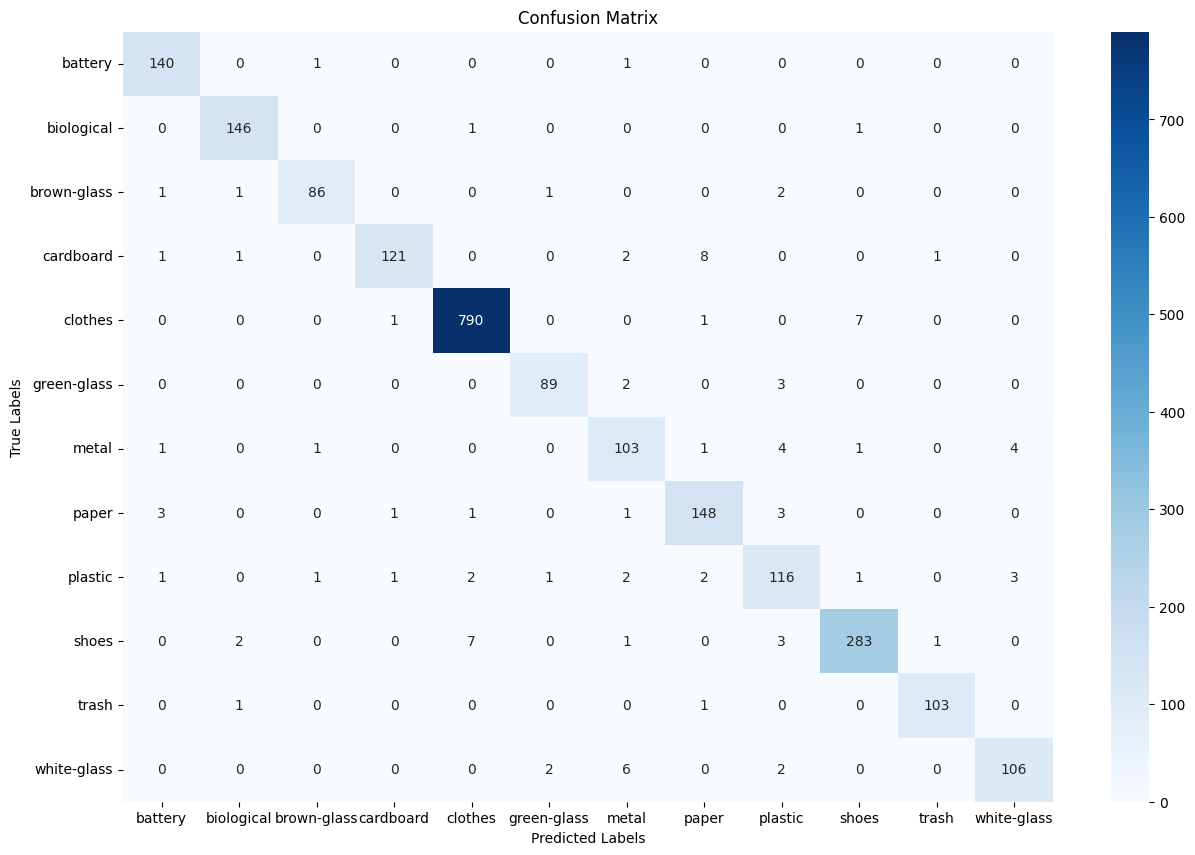

In [32]:
evaluate_model_performance(best_model, validation_generator, classes)

In [33]:
model.save('garbage.h5')

In [1]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open("quantized_garbage_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)

NameError: name 'model' is not defined